# EFC 3 - Redes Neurais - IA048

## Aluno: Jitesh Ashok Manilal Vassaram, RA:175867

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data = np.load('../EFC3/bloodmnist.npz')

In [3]:
TrainX = data["train_images"]
TrainY = data["train_labels"]
ValX = data["val_images"]
ValY = data["val_labels"]
TestX = data["test_images"]
TestY = data["test_labels"]

In [4]:
print(f'dados de treinamento: \n {len(TrainX[0])}')

print('--'*20)
print(f'\n {TrainX/255}')

dados de treinamento: 
 28
----------------------------------------

 [[[[0.98039216 0.8745098  0.80784314]
   [1.         0.89803922 0.83137255]
   [0.98431373 0.87058824 0.80784314]
   ...
   [1.         0.93333333 0.76470588]
   [0.98431373 0.90196078 0.7254902 ]
   [1.         0.91764706 0.74901961]]

  [[1.         0.89803922 0.82352941]
   [1.         0.89803922 0.82352941]
   [0.95686275 0.84313725 0.78039216]
   ...
   [0.99607843 0.90980392 0.75686275]
   [0.99607843 0.91372549 0.74509804]
   [1.         0.94901961 0.78823529]]

  [[1.         0.90588235 0.81568627]
   [1.         0.89019608 0.80392157]
   [0.93333333 0.82352941 0.74117647]
   ...
   [1.         0.91372549 0.79215686]
   [0.98431373 0.89803922 0.75294118]
   [1.         0.94901961 0.79607843]]

  ...

  [[0.91372549 0.8        0.6745098 ]
   [0.9372549  0.82352941 0.70588235]
   [0.96078431 0.85490196 0.7372549 ]
   ...
   [1.         0.88235294 0.78039216]
   [1.         0.88627451 0.78431373]
   [1.         

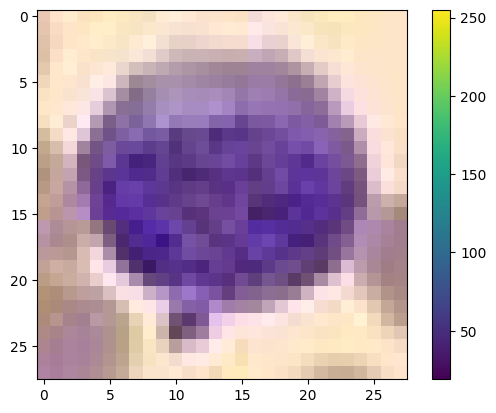

In [5]:
plt.imshow(TestX[0])
plt.colorbar()
plt.show()

In [6]:
TrainX_n = TrainX/255
TestX_n = TestX/255
ValX_n = ValX/255

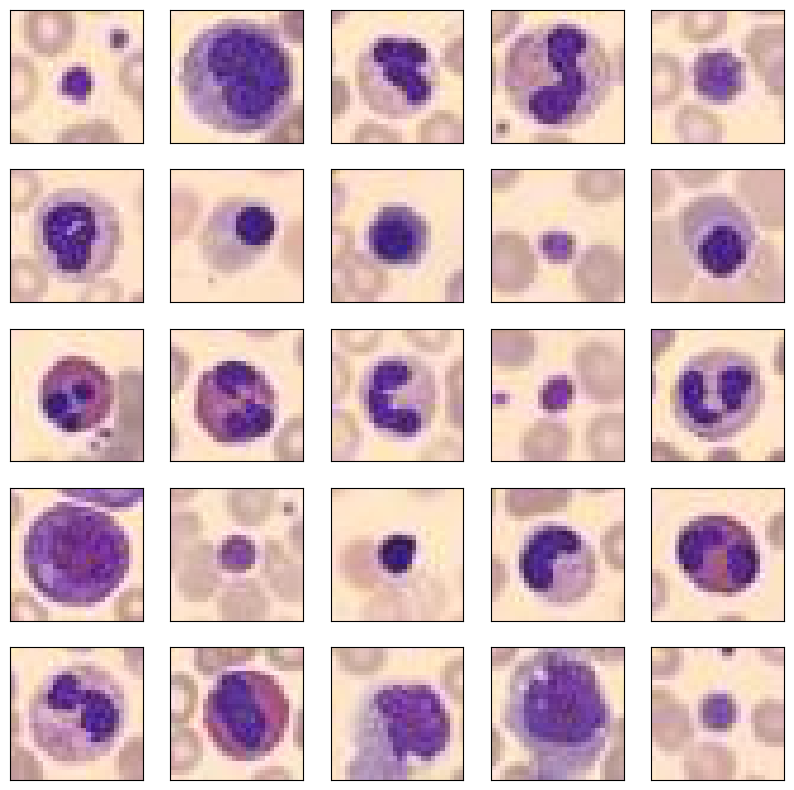

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(TrainX_n[i], cmap=plt.cm.binary)
    # plt.xlabel(class_names[TrainY[i]])
plt.show()

# Criação do modelo CNN profunda

Será implementado uma CNN profunda. Será tomada como base a DenseNet para a construção da CNN.

Para a construção, utilizou-se o seguinte exemplo que aplica uma DenseNet:
[Classificação_KERAS_DenseNet](https://towardsdatascience.com/exploring-densenets-from-paper-to-keras-dcc01725488b)

In [22]:
def H(input, num_filters, dropout_rate,eps):
    
    x = tf.keras.layers.BatchNormalization()(input)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters,kernel_size=(1,1),use_bias=False,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2( eps ))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D((1,1))(x)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3,3),use_bias=False,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2( eps ))(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)

    return x

In [23]:
def transition(inputs, num_filters, compression_factor, dropout_rate,eps):
    
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    num_feature_maps = inputs.shape[1]

    x = tf.keras.layers.Conv2D(np.floor(compression_factor * num_feature_maps).astype(np.int64), kernel_size=(1,1), use_bias=False, padding='same',kernel_initializer='he_normal' , kernel_regularizer=tf.keras.regularizers.l2( eps ) )(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(x)
    return x

In [24]:
def dense_blk(inputs, num_layers, num_filters, growth_rate, dropout_rate,eps):
    
    for i in range(num_layers):
        conv_out = H(inputs, num_filters, dropout_rate,eps)
        inputs = tf.keras.layers.Concatenate()([conv_out,inputs])
        num_filters += growth_rate


    return inputs, num_filters

In [37]:
# Programa Final para construir o modelo.

input_shape = (28,28,3)
eps = 1e-3
num_block = 2
num_layer_pblock = 4
growth_rate = 2
dropout_rate = 0.5
compression_factor = 0.7

num_filters = 2

inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3,3), use_bias=False, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(eps))(inputs)

for i in range(num_block):
    x,num_filters = dense_blk(x, num_layer_pblock, num_filters, growth_rate, dropout_rate,eps)
    x = transition(x, num_filters, compression_factor, dropout_rate,eps)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(8)(x)

output = tf.keras.layers.Activation('softmax')(x)


In [38]:
model = tf.keras.models.Model(inputs, output)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_178 (Conv2D) │ (None, 26, 26, 2) │         54 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26, 2) │          8 │ conv2d_178[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_178      │ (None, 26, 26, 2) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_179 (Conv2D) │ (None, 26, 26, 2) │          4 │ activation_178[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26, 2) │          8 │ conv2d_179[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_179      │ (None, 26, 26, 2) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_73   │ (None, 28, 28, 2) │          0 │ activation_179[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 26, 26, 2) │         36 │ zero_padding2d_7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_96          │ (None, 26, 26, 2) │          0 │ conv2d_180[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_73      │ (None, 26, 26, 4) │          0 │ dropout_96[0][0], │
│ (Concatenate)       │                   │            │ conv2d_178[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26, 4) │         16 │ concatenate_73[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_180      │ (None, 26, 26, 4) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_181 (Conv2D) │ (None, 26, 26, 4) │         16 │ activation_180[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26, 4) │         16 │ conv2d_181[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_181      │ (None, 26, 26, 4) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_74   │ (None, 28, 28, 4) │          0 │ activation_181[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_182 (Conv2D) │ (None, 26, 26, 4) │        144 │ zero_padding2d_7… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,952 (46.69 KB)

 Trainable params: 11,288 (44.09 KB)

 Non-trainable params: 664 (2.59 KB)

In [39]:
batch_size = 16
epochs = 100

# hist = model.fit(datagen.flow(TrainX_n, TrainY, batch_size=batch_size, seed=seed),epochs=epochs, batch_size=batch_size, validation_data=(ValX_n,ValY))
hist = model.fit(TrainX_n,TrainY,epochs=epochs, batch_size=batch_size, validation_data=(ValX_n,ValY),callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True))

Epoch 1/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - acc: 0.4761 - loss: 1.8452 - val_acc: 0.2815 - val_loss: 3.8339
Epoch 2/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - acc: 0.7139 - loss: 0.9730 - val_acc: 0.3627 - val_loss: 2.7534
Epoch 3/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - acc: 0.7713 - loss: 0.8006 - val_acc: 0.4679 - val_loss: 2.3743
Epoch 4/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - acc: 0.7949 - loss: 0.7190 - val_acc: 0.3838 - val_loss: 2.2806
Epoch 5/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - acc: 0.8027 - loss: 0.6808 - val_acc: 0.4182 - val_loss: 2.1654
Epoch 6/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - acc: 0.8149 - loss: 0.6298 - val_acc: 0.3919 - val_loss: 2.9120
Epoch 7/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - acc: 0.8244 - loss: 0.5996 - val_acc: 0.3995 - val_loss: 2.3831
Epoch 8/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - acc: 0.8214 - loss: 0.6022 - val_acc: 0.4089 - val_loss: 2.7233
Epoch 9/100
 88/748 ━━━━━━━━━━━━

KeyboardInterrupt: 

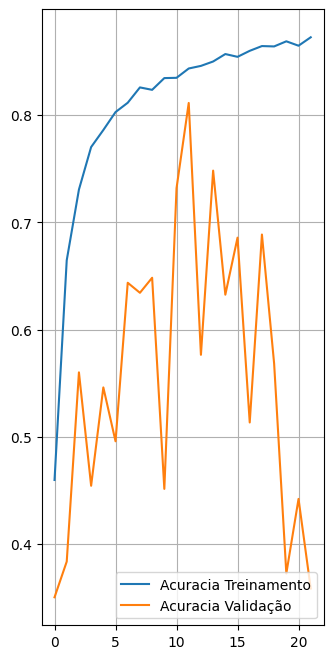

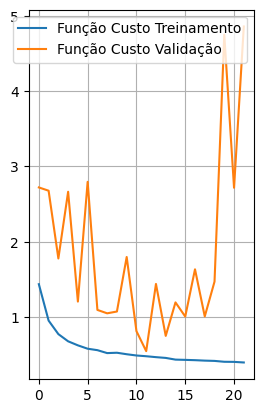

In [36]:
acc = hist.history['acc']
validation_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

range_epochs = np.arange(22)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range_epochs,acc, label='Acuracia Treinamento')
plt.plot(range_epochs,validation_acc, label='Acuracia Validação')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.subplot(1,2,2)
plt.plot(range_epochs,loss, label='Função Custo Treinamento')
plt.plot(range_epochs,val_loss, label='Função Custo Validação')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
import itertools
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

pred = model.predict(TestX_n,batch_size=batch_size)

y_pred = np.empty((len(pred),1),dtype=int)
for i in range(len(pred)):
    y_pred[i,0] = np.argmax(pred[i])

score = model.evaluate(TestX_n,TestY,batch_size=8)

print(f'Função-Custo: {score[0]}')
print(f'Acurácia: {score[1]}')

print('--'*50)

cm = confusion_matrix(TestY,y_pred)
plot_confusion_matrix(cm, ['0', '1', '2', '3', '4', '5', '6', '7'], normalize=False, title='Confusion Matrix')

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')



num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, pred[i], TestY, TestX)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, pred[i], TestY)
plt.tight_layout()
plt.show()



In [ ]:
i = 19
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, pred[i], TestY, TestX)
plt.subplot(1,2,2)
plot_value_array(i, pred[i],  TestY)
plt.show()

In [ ]:
plt.imshow(TestX[10])
plt.show()

In [ ]:
plt.imshow(TestX[33])
plt.show()